<a href="https://colab.research.google.com/github/alyarctiq/tfblog-inceptionv3/blob/master/TFServing-Inceptionv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prep 

In [7]:
# Validate Notebook
try:
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
    print("TF Version: ",  tf.__version__)
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Tensorflow and Keras
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import applications
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import decode_predictions
from tensorflow.keras.preprocessing.image import load_img

# Helper libraries
import os
import requests
import numpy as np
from PIL import Image
from io import BytesIO
from io import BytesIO
import urllib
from matplotlib.pyplot import imshow

tf.keras.backend.clear_session()  # For easy reset of notebook state.

Note: using Google CoLab
TF Version:  2.2.0-rc3


In [3]:
# Load Model
model = InceptionV3(include_top=True, weights='imagenet')

96116736/96112376 [==============================] - 1s 0us/step


In [0]:
def loadImage(URL):
    with urllib.request.urlopen(URL) as url:
        img = image.load_img(BytesIO(url.read()), target_size=(299, 299))

    return img

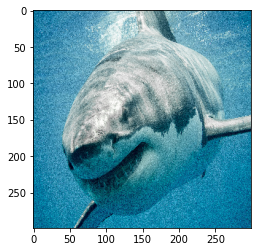

In [8]:
img = loadImage("https://news.harvard.edu/wp-content/uploads/2019/04/iStock-515813368.jpg")
img.save("test.jpg")
w, h = img.size
s = min(w, h)
y = (h - s) // 2
x = (w - s) // 2
img = img.crop((x, y, s, s))
#imshow(np.asarray(img))
target_size = max(x for x in model.layers[0].input_shape if x)
img = img.resize((299, 299), Image.ANTIALIAS)
imshow(np.asarray(img))

In [9]:
np_img = image.img_to_array(img)
img_batch = np.expand_dims(np_img, axis=0)
pre_processed = preprocess_input(img_batch)
pre_processed.shape

(1, 299, 299, 3)

In [10]:
features = model.predict(pre_processed)
features.shape

(1, 1000)

In [11]:
decode_predictions(features, top=5)

40960/35363 [==================================] - 0s 0us/step


[[('n01484850', 'great_white_shark', 0.878036),
  ('n01491361', 'tiger_shark', 0.028002173),
  ('n02071294', 'killer_whale', 0.001973013),
  ('n01494475', 'hammerhead', 0.0011778931),
  ('n02066245', 'grey_whale', 0.0009827499)]]

## Save and Export Model

In [12]:
# Export Path
export_path = '/content/saved_model/v1/'

# Clean Up previous dir
!rm -rf export_path

# Save the entire model as a SavedModel.
!mkdir -p export_path

#save model
tf.saved_model.save(model, os.path.join('/content/',export_path))

# my_model directory
!ls -l /content/saved_model/v1/

#zip and download
from google.colab import files
download_path = 'saved_model/v1.zip'
export_path='saved_model/v1'
!zip -r {download_path} {export_path}

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/saved_model/v1/assets
total 6960
drwxr-xr-x 2 root root    4096 Apr 27 22:35 assets
-rw-r--r-- 1 root root 7115206 Apr 27 22:35 saved_model.pb
drwxr-xr-x 2 root root    4096 Apr 27 22:35 variables
  adding: saved_model/v1/ (stored 0%)
  adding: saved_model/v1/variables/ (stored 0%)
  adding: saved_model/v1/variables/variables.data-00001-of-00002 (deflated 7%)
  adding: saved_model/v1/variables/variables.data-00000-of-00002 (deflated 84%)
  adding: saved_model/v1/variables/variables.index (deflated 80%)
  adding: saved_model/v1/assets/ (stored 0%)
  adding: saved_model/v1/saved_model.pb (deflated 94%)


In [13]:
!ls -R '/content/saved_model/v1/'

/content/saved_model/v1/:
assets	saved_model.pb	variables

/content/saved_model/v1/assets:

/content/saved_model/v1/variables:
variables.data-00000-of-00002  variables.data-00001-of-00002  variables.index


In [14]:
!saved_model_cli show --dir saved_model/v1 --tag_set serve

The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "serving_default"


## Save to Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
!mkdir -p /content/gdrive/"My Drive/colab-download/models"

In [0]:
!cp -R /content/saved_model/v1.zip /content/gdrive/"My Drive/colab-download/models/"

In [0]:
## Clean Up CoLab
!rm -rf '/content/saved_model/v1/'